In [1]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from pycocotools.coco import COCO

In [2]:
# --------------------------------------------------
# 1) CHECK GPU & SETUP
# --------------------------------------------------
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [3]:
# --------------------------------------------------
# 2) PATHS & ANNOTATIONS
# --------------------------------------------------
train_dir = "train"
valid_dir = "valid"
test_dir  = "test"

In [4]:
train_annotations = "_annotations_train.coco.json"
valid_annotations = "_annotations_valid.coco.json"
test_annotations  = "_annotations_test.coco.json"

In [5]:
# --------------------------------------------------
# 3) DATA LOADING
# --------------------------------------------------
def load_coco_dataset(image_dir, annotation_file):
    """
    Loads images and corresponding masks from a COCO-style dataset folder.
    Images and masks are resized to 256x256.
    """
    file_path = os.path.join(image_dir, annotation_file)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Annotation file {file_path} not found.")
    
    coco = COCO(file_path)
    images, masks = [], []

    for image_id in coco.getImgIds():
        # Load image
        image_info = coco.loadImgs(image_id)[0]
        img_path = os.path.join(image_dir, image_info['file_name'])
        if not os.path.exists(img_path):
            print(f"Image file {img_path} not found. Skipping...")
            continue

        # Resize and normalize image
        image = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0

        # Load annotation mask
        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)

        mask = np.zeros((256, 256), dtype=np.float32)

        for ann in anns:
            binary_mask = coco.annToMask(ann)
            # Resize mask to 256x256 if needed
            if binary_mask.shape != (256, 256):
                binary_mask = tf.image.resize(binary_mask[..., None], (256, 256))
                binary_mask = tf.squeeze(binary_mask).numpy()
            mask = np.maximum(mask, binary_mask)

        # Expand mask to (256,256,1)
        mask = mask[..., None]

        images.append(image_array)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [6]:
X_train, y_train = load_coco_dataset(train_dir, train_annotations)
X_val,   y_val   = load_coco_dataset(valid_dir, valid_annotations)
X_test,  y_test  = load_coco_dataset(test_dir,  test_annotations)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2025-01-07 22:47:53.347380: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-07 22:47:53.347407: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-07 22:47:53.347415: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-07 22:47:53.347731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-07 22:47:53.347755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
print(f"Training data:   {X_train.shape}, {y_train.shape}")
print(f"Validation data: {X_val.shape},   {y_val.shape}")
print(f"Test data:       {X_test.shape},   {y_test.shape}")

Training data:   (1502, 256, 256, 3), (1502, 256, 256, 1)
Validation data: (429, 256, 256, 3),   (429, 256, 256, 1)
Test data:       (215, 256, 256, 3),   (215, 256, 256, 1)


In [8]:
# --------------------------------------------------
# 4) DATA AUGMENTATION
# --------------------------------------------------
data_gen_args = dict(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**data_gen_args)

In [9]:
class CustomDataGenerator(Sequence):
    def __init__(self, img_gen, mask_gen):
        self.img_gen   = img_gen
        self.mask_gen  = mask_gen

    def __len__(self):
        return len(self.img_gen)

    def __getitem__(self, idx):
        x = self.img_gen[idx]
        y = self.mask_gen[idx]
        return x, y

In [33]:
BATCH_SIZE = 8
image_generator = image_datagen.flow(X_train, batch_size=BATCH_SIZE, seed=42)
mask_generator  = mask_datagen.flow(y_train, batch_size=BATCH_SIZE, seed=42)
train_generator = CustomDataGenerator(image_generator, mask_generator)

In [34]:
# --------------------------------------------------
# 5) CUSTOM METRICS & LOSSES
# --------------------------------------------------
def iou_score(y_true, y_pred, smooth=1e-7):
    """
    Intersection over Union
    We'll threshold y_pred at 0.5 for the predicted mask.
    """
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union        = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [35]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    """
    Dice = (2 * TP) / (2 * TP + FP + FN)
    """
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union        = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

In [36]:
def bce_dice_loss(y_true, y_pred):
    bce  = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coefficient(y_true, y_pred)
    return bce + (1.0 - dice)

In [37]:
# --------------------------------------------------
# 6) U-NET MODEL (SMALLER FOR LOWER ACCURACY)
# --------------------------------------------------
def conv_block(inputs, filters, kernel_size=(3,3), activation='relu', dropout_rate=0.1):
    x = layers.Conv2D(filters, kernel_size, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

In [38]:
def encoder_block(inputs, filters, dropout_rate=0.1):
    x = conv_block(inputs, filters, dropout_rate=dropout_rate)
    p = layers.MaxPooling2D((2,2))(x)
    return x, p

In [39]:
def decoder_block(inputs, skip, filters, dropout_rate=0.1):
    x = layers.Conv2DTranspose(filters, (2,2), strides=(2,2), padding='same')(inputs)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters, dropout_rate=dropout_rate)
    return x

In [41]:
def unet_smaller(input_size=(256, 256, 3)):
    """ 
    A smaller U-Net to intentionally have less capacity 
    (16 → 32 → 64 → 128 → 256).
    """
    inputs = layers.Input(input_size)

    # Encoder
    c1, p1 = encoder_block(inputs, 16, dropout_rate=0.1)
    c2, p2 = encoder_block(p1,     32, dropout_rate=0.1)
    c3, p3 = encoder_block(p2,     64, dropout_rate=0.2)
    c4, p4 = encoder_block(p3,    128, dropout_rate=0.2)

    # Bottleneck
    b1 = conv_block(p4, 256, dropout_rate=0.3)

    # Decoder
    d1 = decoder_block(b1, c4, 128, dropout_rate=0.2)
    d2 = decoder_block(d1, c3, 64,  dropout_rate=0.2)
    d3 = decoder_block(d2, c2, 32,  dropout_rate=0.1)
    d4 = decoder_block(d3, c1, 16,  dropout_rate=0.1)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs, outputs, name="U-Net_Smaller")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=bce_dice_loss,
        metrics=["accuracy", iou_score, dice_coefficient]
    )
    return model

In [42]:
model = unet_smaller()

In [43]:
# --------------------------------------------------
# 7) TRAINING
# --------------------------------------------------
EPOCHS = 50
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("unet_small_best_model.keras", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
]

In [44]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


/Users/arunalagusunthram/Desktop/Dev/AI/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 120s 544ms/step - accuracy: 0.9151 - dice_coefficient: 0.0804 - iou_score: 0.0438 - loss: 1.2794 - val_accuracy: 0.4540 - val_dice_coefficient: 0.1110 - val_iou_score: 0.0588 - val_loss: 1.9615 - learning_rate: 0.0010
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9653 - dice_coefficient: 0.2577 - iou_score: 0.1479 - loss: 0.8841 - val_accuracy: 0.4329 - val_dice_coefficient: 0.1120 - val_iou_score: 0.0593 - val_loss: 1.8496 - learning_rate: 0.0010
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 101s 542ms/step - accuracy: 0.9637 - dice_coefficient: 0.2868 - iou_score: 0.1721 - loss: 0.8485 - val_accuracy: 0.9580 - val_dice_coefficient: 0.3519 - val_iou_score: 0.2145 - val_loss: 0.8053 - learning_rate: 0.0010
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9677 - dice_coefficient: 0.3798 - iou_score: 0.2344 - loss: 0.7172 - val_accuracy: 0.9577 - val_dice_coefficient: 0.3349 - val_iou_score: 0.2022 - val_loss: 0.8252 - learnin

In [45]:
# --------------------------------------------------
# 8) EVALUATE ON TEST SET
# --------------------------------------------------
test_loss, test_acc, test_iou, test_dice = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test IOU: {test_iou:.4f}")
print(f"Test Dice: {test_dice:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9684 - dice_coefficient: 0.5304 - iou_score: 0.3650 - loss: 0.5592
Test Loss: 0.5551
Test Accuracy: 0.9699
Test IOU: 0.3659
Test Dice: 0.5304


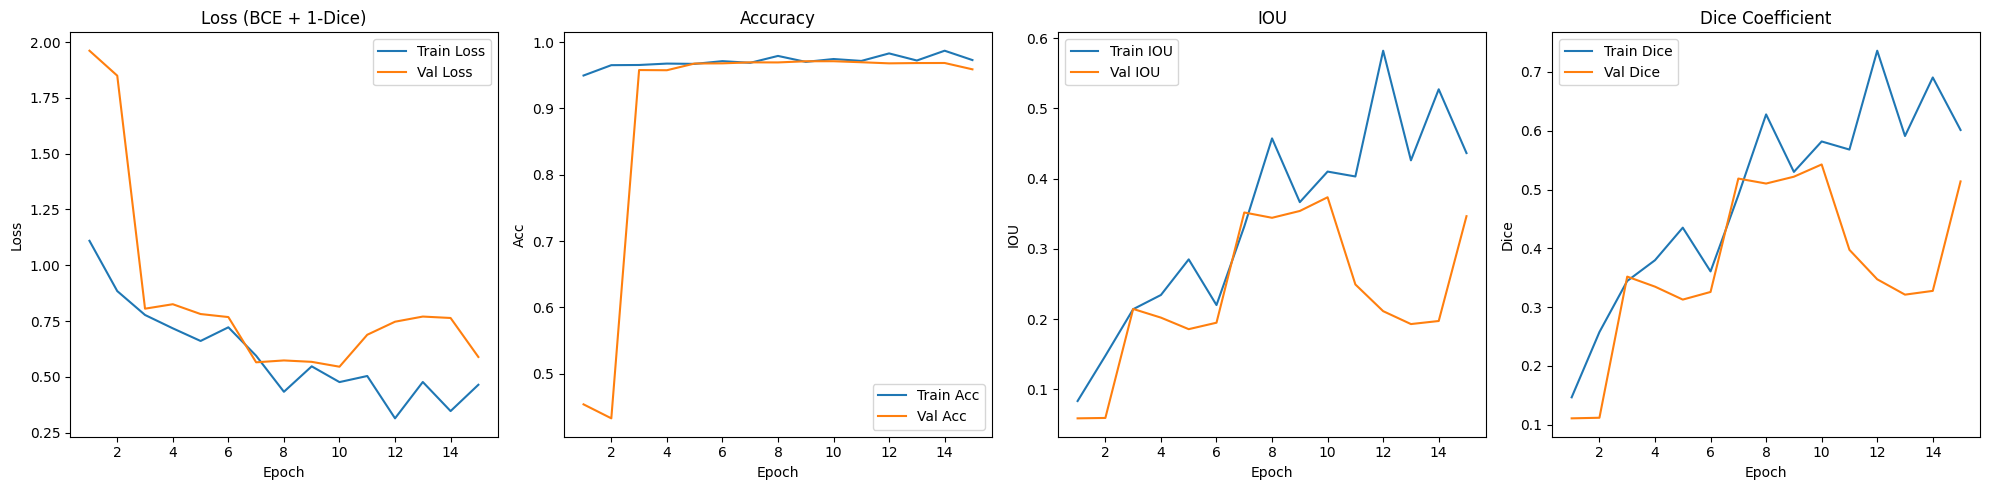

In [46]:
# --------------------------------------------------
# 9) PLOT METRICS
# --------------------------------------------------
epochs_range = range(1, len(history.history['loss'])+1)
plt.figure(figsize=(20,5))

# -- Loss
plt.subplot(1,4,1)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
# plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Loss (BCE + 1-Dice)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# -- Accuracy
plt.subplot(1,4,2)
plt.plot(epochs_range, history.history['accuracy'], label='Train Acc')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val Acc')
# plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

# -- IOU
plt.subplot(1,4,3)
plt.plot(epochs_range, history.history['iou_score'], label='Train IOU')
plt.plot(epochs_range, history.history['val_iou_score'], label='Val IOU')
# plt.axhline(y=test_iou, color='r', linestyle='--', label='Test IOU')
plt.title('IOU')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()

# -- Dice
plt.subplot(1,4,4)
plt.plot(epochs_range, history.history['dice_coefficient'], label='Train Dice')
plt.plot(epochs_range, history.history['val_dice_coefficient'], label='Val Dice')
# plt.axhline(y=test_dice, color='r', linestyle='--', label='Test Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
# --------------------------------------------------
# 10) VISUALIZE PREDICTIONS WITH COLORED OVERLAY
# --------------------------------------------------
def visualize_prediction(img, true_mask, pred_mask, threshold=0.5):
    """
    Overlays ground-truth mask in green and predicted mask in red on the original image.
    img: (256,256,3) in [0,1]
    true_mask: (256,256,1)
    pred_mask: (256,256,1)
    """
    img_rgb = np.clip(img, 0, 1)  # Should already be in [0,1]
    pred_bin = (pred_mask > threshold).astype(np.float32)

    # Make sure we have 3-channel for overlays
    overlay_true = img_rgb.copy()
    overlay_pred = img_rgb.copy()

    # Ground truth in green
    overlay_true[..., 0] = np.where(true_mask[...,0]==1, 0.0, overlay_true[..., 0])
    overlay_true[..., 1] = np.where(true_mask[...,0]==1, 1.0, overlay_true[..., 1])
    overlay_true[..., 2] = np.where(true_mask[...,0]==1, 0.0, overlay_true[..., 2])

    # Predicted in red
    overlay_pred[..., 0] = np.where(pred_bin[...,0]==1, 1.0, overlay_pred[..., 0])
    overlay_pred[..., 1] = np.where(pred_bin[...,0]==1, 0.0, overlay_pred[..., 1])
    overlay_pred[..., 2] = np.where(pred_bin[...,0]==1, 0.0, overlay_pred[..., 2])

    alpha = 0.4
    blended_true = (1 - alpha)*img_rgb + alpha*overlay_true
    blended_pred = (1 - alpha)*img_rgb + alpha*overlay_pred

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(blended_true)
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(blended_pred)
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

In [49]:
# Show 5 random examples
def visualize_predictions(model, X_test, y_test, num=5):
    indices = random.sample(range(len(X_test)), num)
    preds = model.predict(X_test[indices])
    for i, idx in enumerate(indices):
        print(f"--- Sample #{i+1} (Index {idx}) ---")
        img       = X_test[idx]
        true_mask = y_test[idx]
        pred_mask = preds[i]
        visualize_prediction(img, true_mask, pred_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
--- Sample #1 (Index 193) ---


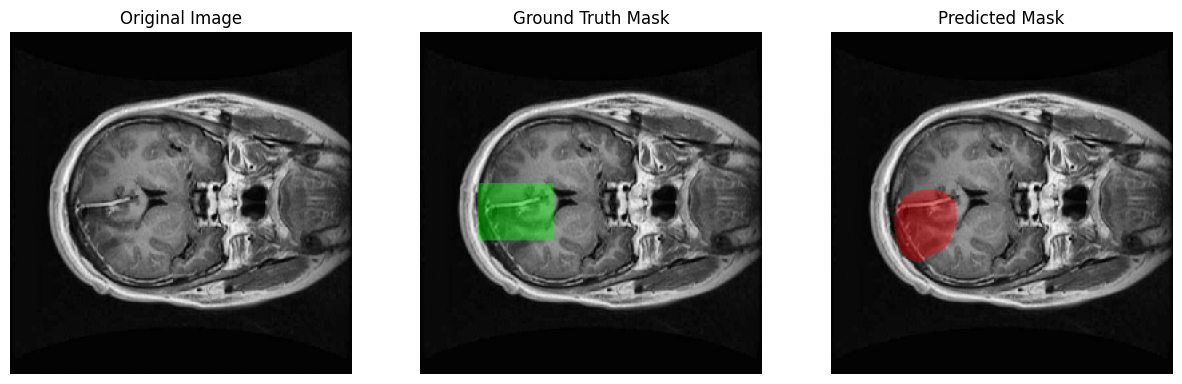

--- Sample #2 (Index 214) ---


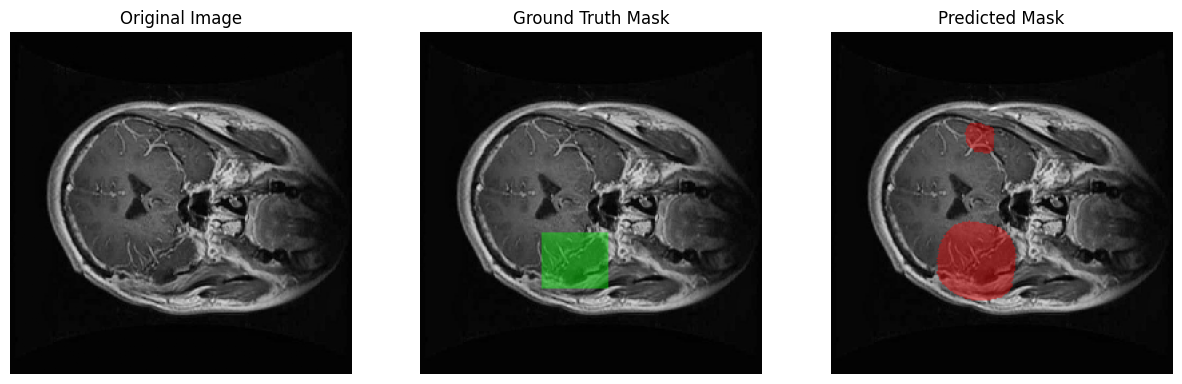

--- Sample #3 (Index 44) ---


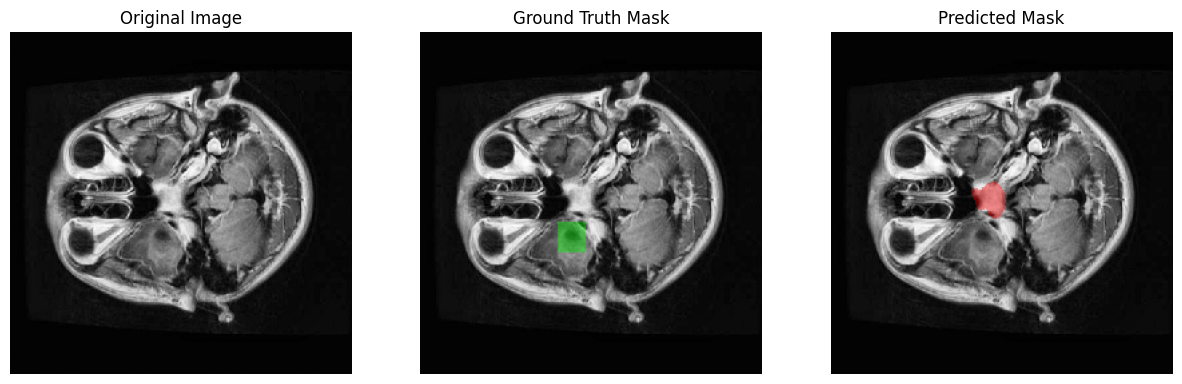

--- Sample #4 (Index 53) ---


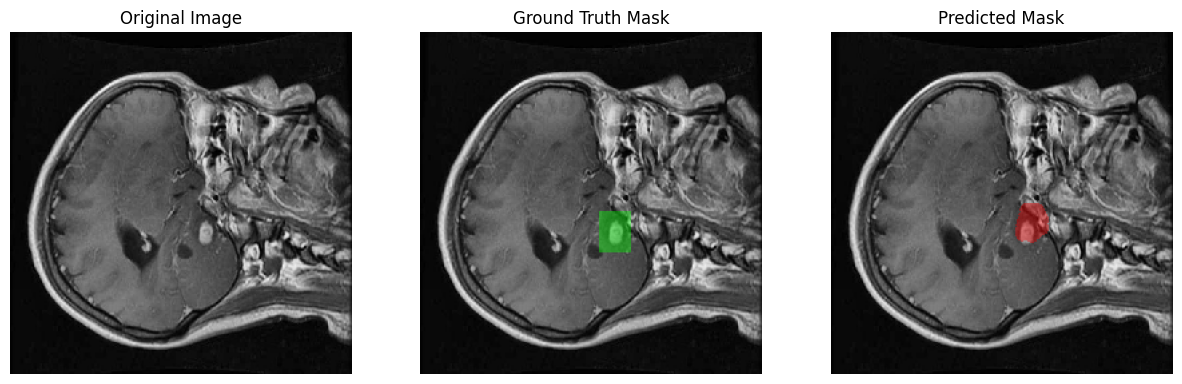

--- Sample #5 (Index 163) ---


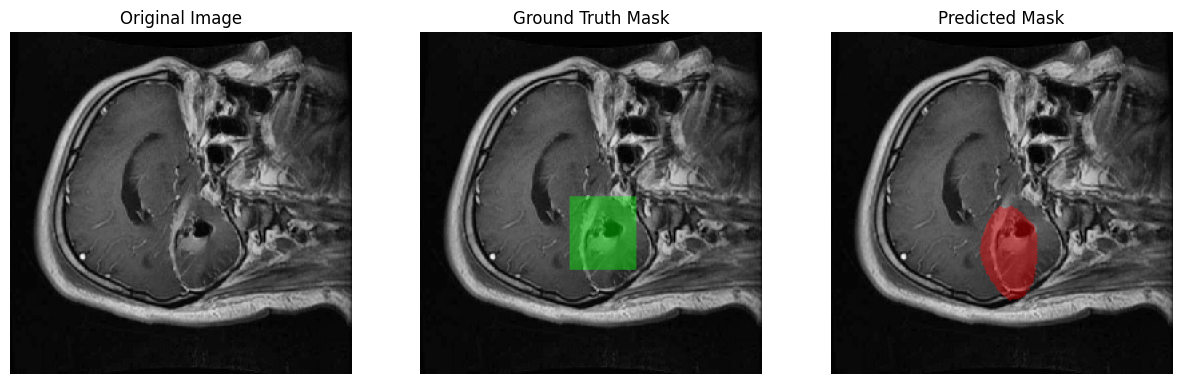

--- Sample #6 (Index 179) ---


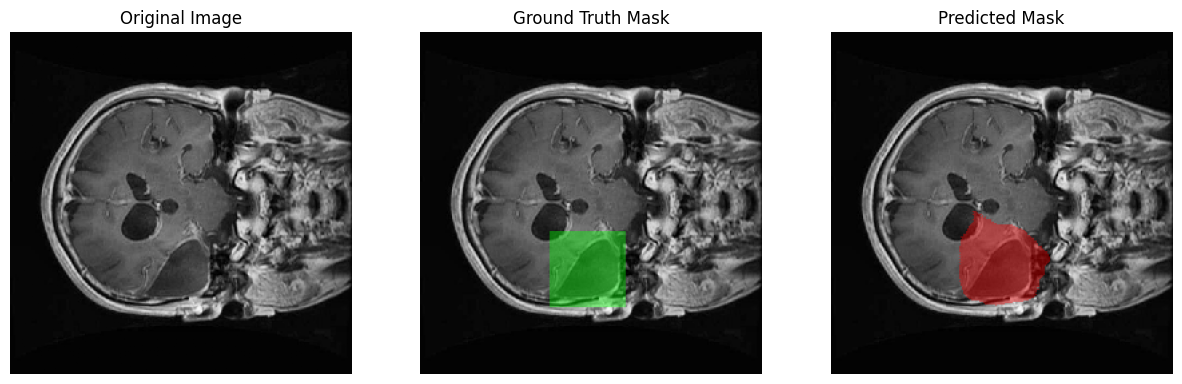

--- Sample #7 (Index 146) ---


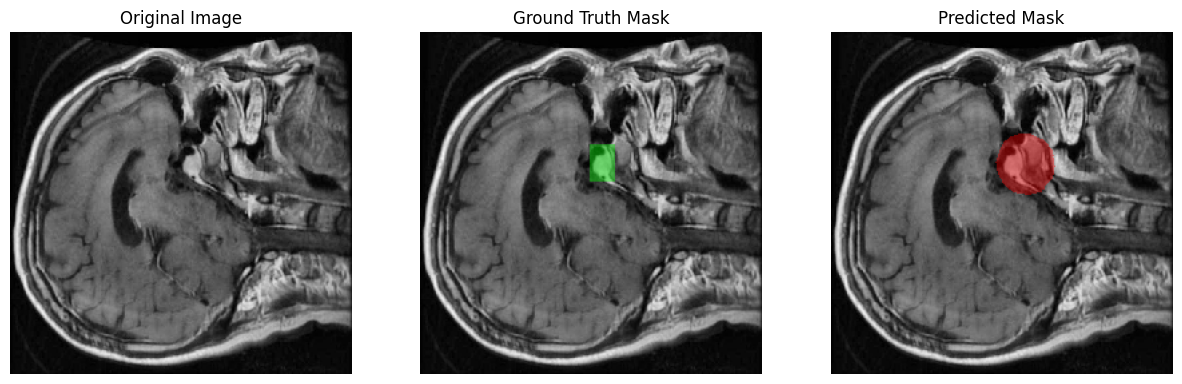

--- Sample #8 (Index 134) ---


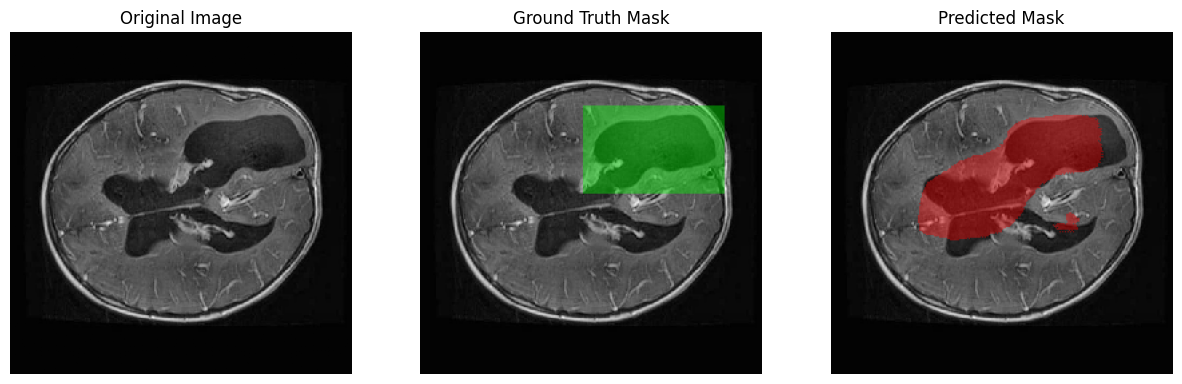

--- Sample #9 (Index 182) ---


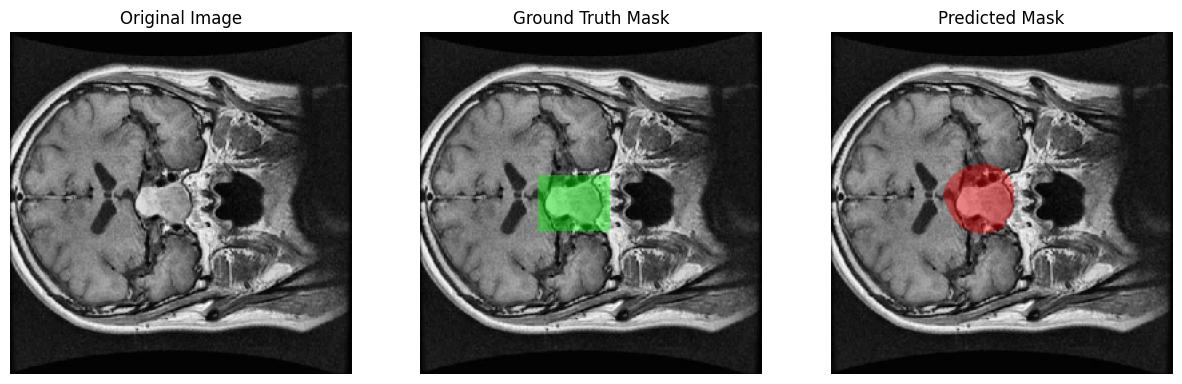

--- Sample #10 (Index 49) ---


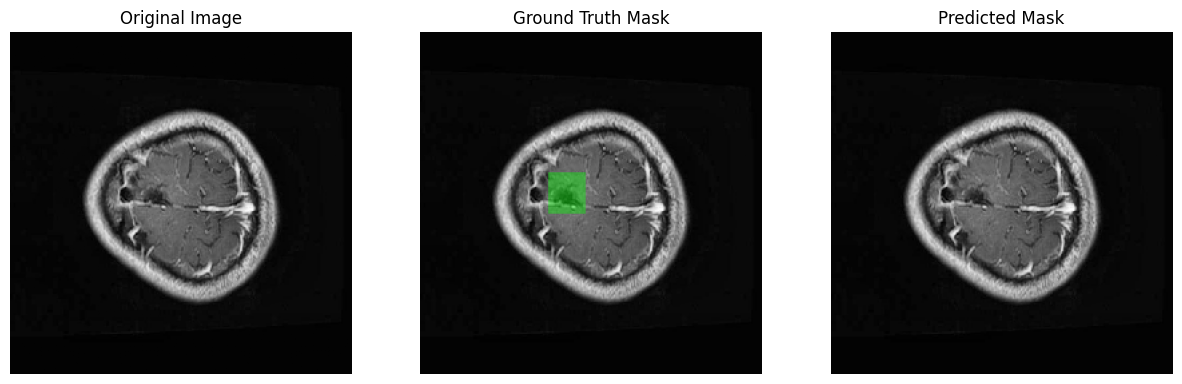

In [50]:
visualize_predictions(model, X_test, y_test, num=10)